![title](MF_main.png "Изображение взято с ресурса https://kod.ru/megafon-cashback-jun-2019/")

Телекоммуникационные компании сейчас существуют не только за счет базовых услуг по предоставлению связи, наподобие обычных звонков и СМС, а уже давно расширяют арсенал возможностей:
* во-первых, для создания клиентской базы, которая будет меньше нуждаться в сторонних решениях (больше пользоваться киносервисом `START` вместо `Кинопоиска` и т.д.)
* во-вторых, для поиска новых путей получения прибыли и сфер влияния.

Именно поэтому важно привлекать новых клиентов к наилучшим предложениям (а также старых уже проверенных абонентов к новым решениям), но делать это необходимо не безраборно, а с максимальной выгодой для компании. Для решения этой проблемы ниже будет рассмотрен алгоритм предложения различных услуг клиентам "Мегафона" в различные временные периоды.

-----

*P.S. Обезличенные исходные данные получены от самих представителей компании, не представляется возможным восстановить какие-либо транзакции и персональные данные на из основе.*

----

Стандартыне процедуры подключения библиотек и загрузок датасетов:

In [243]:
import pandas as pd
import numpy as np
from dask import dataframe as dd
from pathlib import Path
import datetime
from datetime import datetime as dt

from sklearn.linear_model import RidgeClassifierCV, LogisticRegressionCV, LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve

from matplotlib import pyplot as plt

In [2]:
DATA_PATH = Path('Материалы')
FEATS_PATH = DATA_PATH / 'features.csv'

dd_df = dd.read_csv(FEATS_PATH / 'features.csv', sep='\t',)

test_df = pd.read_csv(DATA_PATH / 'data_test.csv', parse_dates=['buy_time'])
train_df = pd.read_csv(DATA_PATH / 'data_train.csv')

In [25]:
# DELETE
DATA_PATH = Path('Материалы')
FEATS_PATH = DATA_PATH / 'features.csv'

dd_df = pd.read_csv(FEATS_PATH / 'mod_features.csv')

test_df = pd.read_csv(DATA_PATH / 'data_test.csv', parse_dates=['buy_time'])
train_df = pd.read_csv(DATA_PATH / 'data_train.csv')

idx_column = 'Unnamed: 0'

train_df.drop(columns=idx_column, inplace=True)
test_df.drop(columns=idx_column, inplace=True)
dd_df.drop(columns=idx_column, inplace=True)
dd_df_filtered.buy_time = dd_df_filtered.buy_time.astype('datetime64[ns]')

test_df['buy_time'] = pd.to_datetime(test_df['buy_time'], unit='s')
train_df['buy_time'] = pd.to_datetime(train_df['buy_time'], unit='s')


In [85]:
dd_df = dd.read_csv(FEATS_PATH / 'features.csv', sep='\t',)

### Mini-EDA

In [3]:
test_df.head()

,Unnamed: 0,id,vas_id,buy_time
0,0,3130519,2.0,1548018000
1,1,2000860,4.0,1548018000
2,2,1099444,2.0,1546808400
3,3,1343255,5.0,1547413200
4,4,1277040,2.0,1546808400


In [4]:
dd_df.head()

,Unnamed: 0,id,buy_time,0,1,2,3,4,5,6,...,243,244,245,246,247,248,249,250,251,252
0,0,2013026,1531688400,18.910029,46.980888,4.969214,-1.386798,3.791754,-14.01179,-16.08618,...,-977.373846,-613.770792,-25.996269,-37.630448,-301.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
1,1,2014722,1539550800,36.690029,152.400888,448.069214,563.833202,463.841754,568.99821,-16.08618,...,-891.373846,-544.770792,-20.996269,48.369552,80.252276,-13.832889,-0.694428,-1.175933,-0.45614,0.0
2,2,2015199,1545598800,-67.019971,157.050888,-63.180786,178.103202,-68.598246,156.99821,3.51382,...,-977.373846,-613.770792,-12.996269,-37.630448,10829.252276,-25.832889,-0.694428,-12.175933,-0.45614,0.0
3,3,2021765,1534107600,7.010029,150.200888,-6.930786,216.213202,76.621754,351.84821,-16.08618,...,-973.373846,-613.770792,-23.996269,-37.630448,-205.747724,-24.832889,-0.694428,-11.175933,-0.45614,1.0
4,4,2027465,1533502800,-90.439971,134.220888,-104.380786,153.643202,-109.798246,132.53821,-16.08618,...,1643.626154,2007.229208,206.003731,-21.630448,6667.252276,92.167111,-0.694428,49.824067,47.54386,0.0


Как видно, исходные списки предложений о подключениях содержат только `id`абонента, VAS услуги и времени в формате **timestamp[s]**, в таком же формате находится и время в таблице признаков. Переведем их в более привычный **datetime** (также столбцы `Unnamed: 0` во всех выгрузках играют роль индекса и неинформативны, их можно в дальнейшем удалить):

In [8]:
%%time
test_df['buy_time'] = pd.to_datetime(test_df['buy_time'], unit='s')
train_df['buy_time'] = pd.to_datetime(train_df['buy_time'], unit='s')

dtime = dd_df.buy_time
dd_df['buy_time'] = dtime.map_partitions(pd.to_datetime, unit='s')

Wall time: 55 ms


In [6]:
test_df.head()

,Unnamed: 0,id,vas_id,buy_time
0,0,3130519,2.0,2019-01-20 21:00:00
1,1,2000860,4.0,2019-01-20 21:00:00
2,2,1099444,2.0,2019-01-06 21:00:00
3,3,1343255,5.0,2019-01-13 21:00:00
4,4,1277040,2.0,2019-01-06 21:00:00


Можно заметить, что первые значения имеют одинаковое время, но разную дату. Это наталкивает на мысль о том, что в выгрузках данные с достаточно крупными агрегациями - раз в день -, что будет достаточно сильно ограничивать дальнейшую аналитику. Если по всей выборке время будет одинаковым, то гипотезу точно можно будет считать верной:

In [26]:
pd.to_datetime(train_df['buy_time'], unit='s').dt.hour.unique()

array([21], dtype=int64)

In [28]:
dtime = dd_df.buy_time
dtime.map_partitions(pd.to_datetime, unit='s').dt.hour.unique().compute()

0    21
Name: buy_time, dtype: int64

Действительно, агрегация данных на текущий момент как минимум суточная (далее проверим на более крупную). Исходя из этого возникает ряд проблем:
* нельзя рассматривать отдельно случаи подключения абонентов в разное время суток;
* нельзя однозначно сказать, конкретное измерение относилось к текущим суткам или следуюшим из-за того, что ЧНН активности пользователей часто близок к вечерним часам. Наиболее удачное решение было бы сместить время примерно к 3-4 часам ночи - наименьшей активности абонентов.

Выведем список всех значений дат, т.к. агрегация минимум дневная и датасет содержит данные за 4 месяца, то строк не должно быть много:

In [30]:
np.sort(pd.to_datetime(train_df['buy_time'], unit='s').unique())

array(['2018-07-08T21:00:00.000000000', '2018-07-15T21:00:00.000000000',
       '2018-07-22T21:00:00.000000000', '2018-07-29T21:00:00.000000000',
       '2018-08-05T21:00:00.000000000', '2018-08-12T21:00:00.000000000',
       '2018-08-19T21:00:00.000000000', '2018-08-26T21:00:00.000000000',
       '2018-09-02T21:00:00.000000000', '2018-09-09T21:00:00.000000000',
       '2018-09-16T21:00:00.000000000', '2018-09-23T21:00:00.000000000',
       '2018-09-30T21:00:00.000000000', '2018-10-07T21:00:00.000000000',
       '2018-10-14T21:00:00.000000000', '2018-10-21T21:00:00.000000000',
       '2018-10-28T21:00:00.000000000', '2018-11-04T21:00:00.000000000',
       '2018-11-11T21:00:00.000000000', '2018-11-18T21:00:00.000000000',
       '2018-11-25T21:00:00.000000000', '2018-12-02T21:00:00.000000000',
       '2018-12-09T21:00:00.000000000', '2018-12-16T21:00:00.000000000',
       '2018-12-23T21:00:00.000000000', '2018-12-30T21:00:00.000000000'],
      dtype='datetime64[ns]')

In [31]:
np.sort(pd.to_datetime(test_df['buy_time'], unit='s').unique())

array(['2019-01-06T21:00:00.000000000', '2019-01-13T21:00:00.000000000',
       '2019-01-20T21:00:00.000000000'], dtype='datetime64[ns]')

In [28]:
dd_dt = dtime.map_partitions(pd.to_datetime, unit='s')
dd_dt = np.array(dd_dt.unique().compute())
np.sort(dd_dt)

array(['2018-07-08T21:00:00.000000000', '2018-07-15T21:00:00.000000000',
       '2018-07-22T21:00:00.000000000', '2018-07-29T21:00:00.000000000',
       '2018-08-05T21:00:00.000000000', '2018-08-12T21:00:00.000000000',
       '2018-08-19T21:00:00.000000000', '2018-08-26T21:00:00.000000000',
       '2018-09-02T21:00:00.000000000', '2018-09-09T21:00:00.000000000',
       '2018-09-16T21:00:00.000000000', '2018-09-23T21:00:00.000000000',
       '2018-09-30T21:00:00.000000000', '2018-10-07T21:00:00.000000000',
       '2018-10-14T21:00:00.000000000', '2018-10-21T21:00:00.000000000',
       '2018-10-28T21:00:00.000000000', '2018-11-04T21:00:00.000000000',
       '2018-11-11T21:00:00.000000000', '2018-11-18T21:00:00.000000000',
       '2018-11-25T21:00:00.000000000', '2018-12-02T21:00:00.000000000',
       '2018-12-09T21:00:00.000000000', '2018-12-16T21:00:00.000000000',
       '2018-12-23T21:00:00.000000000', '2018-12-30T21:00:00.000000000',
       '2019-01-06T21:00:00.000000000', '2019-01-13

Как оказалось, агрегация здесь даже недельная, что убирает возможность анализировать поведение пользователей и на выходных/праздничных днях, а также остается мало смысла рассматривать дату как важную фичу за такой короткий промежуток времени.

А также стоит заметить, что на `test` датасете имеем дело с неделей в начале года, что очень сильно может влиять на конечные результаты предсказания. Было бы крайне хорошо иметь прошлогодние данные за этот же промежуток.

----

Оценим полезность наших дат, можно ли строить историю для каждого пользователя и т.д.:

In [52]:
%%time
id_cnt = dd_df.groupby('id')['id'].count().compute()
id_cnt[id_cnt > 1].sort_values()

Wall time: 3min 26s


id
1318       2
6971       2
7637       2
9264       2
14368      2
          ..
3410244    2
3537081    2
3620266    2
4313991    2
2422554    2
Name: id, Length: 119977, dtype: int64

Т.к. для каждого абонента имеются максимум по 2 записи (в крайне малом объеме - около 3% от всех), ни о какой историчности и сбору статистик по подключенным услугам у конкретного абонента нельзя говорить.

В таком случае можно попробовать посмотреть на общую динамику по каждой услуге и оценить ее:

In [203]:
group_df = pd.DataFrame(train_df.groupby(['vas_id', 'buy_time'])['target'].agg(['count', 'mean'])).reset_index()
group_df.vas_id = group_df.vas_id.astype('int')

timeline = np.sort(group_df.buy_time.dt.date.unique())

group_df.head()

,vas_id,buy_time,count,mean
0,1,2018-07-08 21:00:00,4427,0.014909
1,1,2018-07-15 21:00:00,7935,0.013359
2,1,2018-07-22 21:00:00,38507,0.012465
3,1,2018-07-29 21:00:00,6313,0.016316
4,1,2018-08-05 21:00:00,29643,0.009378


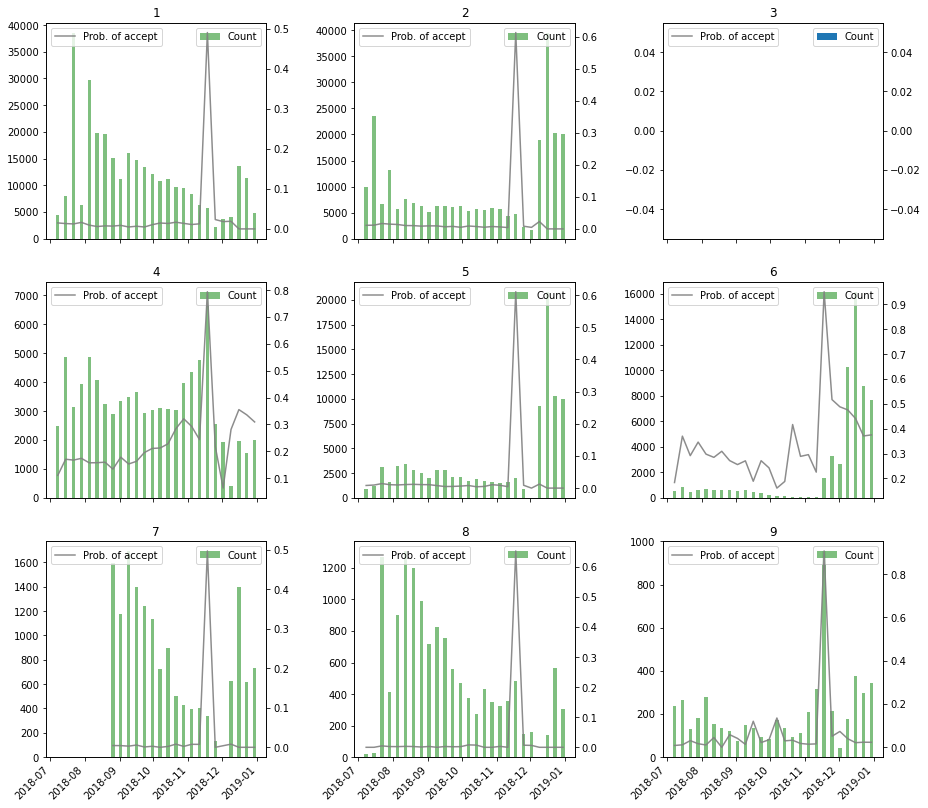

In [193]:
fig, axes = plt.subplots(3, 3, sharex=True)
plt.subplots_adjust(wspace=0.4)
fig.set_size_inches(15, 15)
fig.autofmt_xdate(rotation=45)
axes = axes.flatten()

for vas_id, ax in zip(range(1, 10), axes):    
    ox = group_df.loc[group_df.vas_id == vas_id, 'buy_time'].dt.date

    oy1 = group_df.loc[group_df.vas_id == vas_id, 'count']
    oy2 = group_df.loc[group_df.vas_id == vas_id, 'mean']
    
    ax2 = ax.twinx()
    
    x_ticks = ox
    ax.bar(ox, oy1, color='g', width=3, alpha=0.5, label='Count')
    ax2.plot(ox, oy2, 'b-', color='grey', alpha=0.9, label='Prob. of accept')
#     ax.set_xticks(ox)
#     ax.set_xticklabels(timeline, rotation=45)
    ax.legend(loc=1)
    ax2.legend(loc=2)
    ax.set_title(vas_id)
#     ax.set_ylabel('Баллы')


In [218]:
group_df.sort_values('mean', ascending=False).reset_index().iloc[0]

index                       123
vas_id                        6
buy_time    2018-11-18 21:00:00
count                      1560
mean                   0.951282
Name: 0, dtype: object

Можно выделить несколько моментов:
* с декабря 2018 года активно начались рекламные кампании у услуг 2, 5, 6;
* виден всплеск как приглашение к подключению услуг, так и успешность подключения (вплоть до 95%) за неделю с 2018-11-18, что наводит на мысль о некорректных данных, можно будет считать этот период выбросом и дополнительно анализировать его отдельно при наличии дополнительных данных оператора;
* практически все услуги подключаются с крайне небольшим процентом, исключение составляются лишь 6, 4 и 9 (сильно позади)

In [204]:
train_df['target'].mean()

0.07236912510385943

In [107]:
train_df.groupby('vas_id')['target'].agg(['mean', 'count'])

,mean,count
vas_id,,
1.0,0.018261,310175
2.0,0.019226,249505
4.0,0.253801,85756
5.0,0.017984,94085
6.0,0.426829,57878
7.0,0.013802,15432
8.0,0.025993,13350
9.0,0.183480,5472


Подтвердились предположения о успехе подключений 6, 4 и 9 услуг, причем нумерация услуг скорее всего велась по снижения числа пользователей с ней (если это так, то можно сказать о том, что абонентов с успешно подключенной 4 услугой на тестовом датасете больше, чем с 5 :) )

-----

### Оптимизация

Так как датасет достаточно объемный и текущая рабочая машина не позволяет достаточно быстро работать с ним полностью из оперативной памяти, предлагается убрать из него все лишнее и по возможности затем работать pandas датафреймом:

Уберем всех пользователей из `features`, которых нет в `train` и `test`:

In [59]:
ids = set(list(train_df.id.unique()) + list(test_df.id.unique()))
dd_df = dd_df[dd_df.id.isin(ids)]
dd_df.head()

,Unnamed: 0,id,buy_time,0,1,2,3,4,5,6,...,243,244,245,246,247,248,249,250,251,252
13,13,2046132,2018-08-19 21:00:00,300.820029,1599.480888,286.879214,1585.013202,281.461754,1563.90821,-16.08618,...,-977.373846,-613.770792,-25.996269,-35.630448,-295.747724,-17.832889,-0.694428,-4.175933,-0.45614,0.0
16,16,2050810,2018-10-28 21:00:00,-86.209971,91.820888,-84.480786,110.333202,-89.898246,89.22821,-16.08618,...,-977.373846,-613.770792,-23.996269,190.369552,-286.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
19,19,2070757,2018-10-28 21:00:00,-96.799971,-408.179112,-110.740786,-460.786798,-114.038246,-479.77179,-16.08618,...,-925.373846,-561.770792,-21.996269,-37.630448,-151.747724,-24.832889,0.305572,-12.175933,-0.45614,1.0
20,20,2071522,2018-12-16 21:00:00,-94.939971,-363.699112,-108.880786,-411.226798,-114.298246,-432.33179,-16.08618,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
22,22,2075318,2018-08-05 21:00:00,-75.639971,669.690888,-89.580786,732.343202,-94.998246,736.65821,-16.08618,...,-501.373846,-242.770792,-25.996269,-37.630448,-167.747724,-14.832889,2.305572,-4.175933,-0.45614,0.0


Далее уберем колонки, не несущие информации, а также те признаки, которые являются очень сильно коррелирующими между друг другом:

In [21]:
idx_column = 'Unnamed: 0'

train_df.drop(columns=idx_column, inplace=True)
test_df.drop(columns=idx_column, inplace=True)
dd_df.drop(columns=idx_column, inplace=True).compute()

In [65]:
%%time

corr_all = dd_df.corr().compute()
corr_all.loc[:,:] = np.tril(corr_all, k=-1) 

Wall time: 23min 18s


In [81]:
threshold = 0.90

already_in = set()
result = []
for col in corr_all:
    perfect_corr = corr_all[col][np.abs(corr_all[col]) >= threshold ].index.tolist()
    if perfect_corr and col not in already_in:
        already_in.update(set(perfect_corr))
        perfect_corr.append(col)
        result.append(perfect_corr)

In [82]:
result

[['2', '4', '0'],
 ['3', '1'],
 ['8', '11', '78', '79', '6'],
 ['71', '10'],
 ['72', '12'],
 ['14', '13'],
 ['35', '17'],
 ['104', '19'],
 ['24', '23'],
 ['33', '32'],
 ['116', '38'],
 ['112', '39'],
 ['113', '40'],
 ['123', '41'],
 ['124', '42'],
 ['45', '186', '43'],
 ['170', '44'],
 ['184', '46'],
 ['51', '151', '50'],
 ['147', '162', '54'],
 ['104', '76'],
 ['88', '83'],
 ['92', '91'],
 ['142', '101'],
 ['137', '135'],
 ['138', '136'],
 ['180', '179'],
 ['217', '209'],
 ['220', '216'],
 ['234', '230']]

*P.S. Здесь в каждом элементе списка отображен список названий признаков, имеющих корреляцию выше 0.9 (гибкий параметр)*

In [90]:
to_delete = ['Unnamed: 0']

for clmns in result:
    to_delete += clmns[1:]

Также удалим все признаки, имеющие константные значения в датасете:

In [112]:
feats_var = dd_df.var().compute()
feats_wo_info = list(feats_var[feats_var == 0].index)
feats_wo_info

['75', '81', '85', '139', '203']

In [114]:
dd_df.drop(columns=to_delete + feats_wo_info)

И далее считаем полученные данные как стаданртный `DataFrame` `pandas` для оптимизации быстродействия

In [122]:
dd_df.to_csv(FEATS_PATH / 'mod_features.csv', single_file=True)
dd_df = pd.read_csv(FEATS_PATH / 'mod_features.csv')

Объединим полученные датасет с исходными данными:

In [78]:
max_delta = train_df.buy_time.max() - dd_df.buy_time.min()

merged_train_df = pd.merge_asof(train_df.sort_values('buy_time'),
                                  dd_df.sort_values('buy_time'),
                                  by='id',
                                  on='buy_time',
                                  tolerance=max_delta,
                                  direction='backward'
                                 ).sort_values('id')
merged_train_df

,id,vas_id,buy_time,target,2,3,5,7,8,9,...,243,244,245,246,247,248,249,250,251,252
733315,2,2.0,2018-12-23 21:00:00,0.0,-110.740786,305.723202,284.61821,-65.076097,-6.78366,-30.006538,...,2300.626154,1492.229208,-21.996269,-35.630448,368.252276,11.167111,7.305572,-12.175933,-0.45614,0.0
178087,4,1.0,2018-08-05 21:00:00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
183447,15,1.0,2018-08-12 21:00:00,0.0,249.409214,140.873202,119.76821,317.953903,-6.78366,-30.006538,...,-381.373846,-613.770792,-24.996269,-31.630448,-212.747724,108.167111,-0.694428,107.824067,13.54386,1.0
500241,16,2.0,2018-10-28 21:00:00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
176943,29,1.0,2018-08-05 21:00:00,0.0,-36.590786,-248.926798,-270.03179,-65.076097,-6.78366,-30.006538,...,-847.373846,-509.770792,-25.996269,-37.630448,-233.747724,-10.832889,-0.694428,2.824067,-0.45614,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
793142,4362634,1.0,2018-12-30 21:00:00,0.0,-110.740786,-130.286798,-151.39179,-65.076097,-6.78366,-30.006538,...,-26.373846,-613.770792,118.003731,98.369552,-219.747724,151.167111,-0.694428,-12.175933,-0.45614,0.0
791222,4362640,2.0,2018-12-30 21:00:00,0.0,-105.190786,-107.776798,-128.88179,-65.076097,-6.78366,-30.006538,...,-974.373846,-610.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,1.0
791374,4362647,6.0,2018-12-30 21:00:00,0.0,363.839214,284.973202,263.86821,-65.076097,-6.78366,-30.006538,...,1351.626154,745.229208,-25.996269,-28.630448,26.252276,34.167111,-0.694428,47.824067,-0.45614,0.0
741257,4362684,5.0,2018-12-23 21:00:00,0.0,-27.720786,34.053202,46.84821,-65.076097,-6.78366,-30.006538,...,-598.373846,-283.770792,-22.996269,-34.630448,-208.747724,-10.832889,-0.694428,2.824067,-0.45614,1.0


In [84]:
null_cnt = merged_train_df.isnull().sum().max()
null_cnt, null_cnt / merged_train_df.shape[0]

(422929, 0.5085402205006174)

Как видно, почти половина пользователей не имеют признаков, а это может значить, что набор данных `features` не снимался в те периоды времени, в которые происходило изменение отсутствующей части пользователей, то есть или нужны более давние выгрузки, или необходимо изменить принцип сбора данных в `features` - а именно для недостающих данных снимать эти же признаки с текущего снимка базы данных (HLR, HSS, ...).

Так как часть выборки без данных достаточно весомая, то заменять их на средние, медианы и т.д. не вижу смысла. Считаю, что в данном случае лучше опираться на статистические показатели подключения пользователей, в этом случае у нас будет самый реальный усредненный процент успешного подключения.

------

### Построение модели

Т.к. обучающий сет достаточно большой, можно разбить его на вализационную часть и на обучающую, а также обновить вероятноти подключения:

In [229]:
f_test_df = merged_train_df.loc[merged_train_df.buy_time > dt.strptime('2018-11-25', '%Y-%m-%d')].copy()
f_train_df = merged_train_df.loc[~(merged_train_df.buy_time > dt.strptime('2018-11-25', '%Y-%m-%d')) &\
                          (merged_train_df.buy_time != dt.strptime('2018-11-18 21', '%Y-%m-%d %H'))].copy()

In [230]:
stat_vas = f_train_df.groupby('vas_id')['target'].agg(['mean', 'count']).reset_index()[['vas_id', 'mean']]
stat_vas.vas_id = stat_vas.vas_id.astype('int')
stat_vas

,vas_id,mean
0,1,0.009994
1,2,0.009993
2,4,0.197696
3,5,0.008801
4,6,0.281583
5,7,0.003624
6,8,0.002510
7,9,0.030975


При учитывании спорного периода в неделю с 2018-11-25 значения получаются сильно разные по сравнению с тем, что имели ранее. Поэтому можно изменить полученные значения для 2, 5 и 6 услуг (где начался рост предложений в конце 2018 года), если бизнес будет не против этого, так как скорее на эти услуги сейчас направлен вектор развития и важно охватить как можно большую аудиторию.

In [231]:
stat_vas.loc[stat_vas.vas_id.isin([2, 5, 6]), 'mean'] = stat_vas.loc[stat_vas.vas_id.isin([2, 5, 6]), 'mean']**0.5
stat_vas

,vas_id,mean
0,1,0.009994
1,2,0.099966
2,4,0.197696
3,5,0.093812
4,6,0.530644
5,7,0.003624
6,8,0.002510
7,9,0.030975


Для бейзлайна модели будем использовать логистическую регрессию:

In [232]:
f_train_df

,id,vas_id,buy_time,target,2,3,5,7,8,9,...,243,244,245,246,247,248,249,250,251,252
178087,4,1.0,2018-08-05 21:00:00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
183447,15,1.0,2018-08-12 21:00:00,0.0,249.409214,140.873202,119.76821,317.953903,-6.78366,-30.006538,...,-381.373846,-613.770792,-24.996269,-31.630448,-212.747724,108.167111,-0.694428,107.824067,13.54386,1.0
500241,16,2.0,2018-10-28 21:00:00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
176943,29,1.0,2018-08-05 21:00:00,0.0,-36.590786,-248.926798,-270.03179,-65.076097,-6.78366,-30.006538,...,-847.373846,-509.770792,-25.996269,-37.630448,-233.747724,-10.832889,-0.694428,2.824067,-0.45614,0.0
463846,30,7.0,2018-10-14 21:00:00,0.0,-83.620786,186.223202,167.65821,-65.076097,-6.78366,-30.006538,...,-962.373846,-613.770792,-23.996269,-37.630448,-252.747724,-23.832889,-0.694428,-10.175933,-0.45614,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
548182,4362105,1.0,2018-11-11 21:00:00,0.0,-110.740786,-431.716798,-452.82179,-65.076097,-6.78366,-30.006538,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
458714,4362106,2.0,2018-10-14 21:00:00,0.0,-66.680786,-156.556798,-177.66179,-65.076097,-6.78366,-30.006538,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
467181,4362135,1.0,2018-10-14 21:00:00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
489769,4362253,1.0,2018-10-28 21:00:00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [244]:
f_train_df_nnul = f_train_df.loc[~f_train_df.isna().any(axis=1)]
f_test_df_nnul = f_test_df.loc[~f_test_df.isna().any(axis=1)]

In [246]:
%%time
model = LogisticRegression(n_jobs=-1)
model.fit(f_train_df_nnul.drop(columns=['target', 'buy_time']), f_train_df_nnul.target)
pred = model.predict_proba(f_test_df_nnul.drop(columns=['target', 'buy_time']))

Wall time: 1min 38s


In [257]:
results.loc[f_test_df_nnul.index, 'log_reg']

733315   NaN
664337   NaN
661344   NaN
806084   NaN
746360   NaN
          ..
793142   NaN
791222   NaN
791374   NaN
741257   NaN
792575   NaN
Name: log_reg, Length: 211717, dtype: float64

In [265]:
f_test_df_nnul = f_test_df_nnul.reset_index()
f_test_df_nnul['pred'] = pred
f_test_df_nnul

ValueError: Wrong number of items passed 2, placement implies 1

In [255]:
results = f_test_df[['target']]
results['log_reg'] = np.nan
results.loc[f_test_df_nnul.index, 'log_reg'] = pred
results

<ipython-input-255-8c89721f75e8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['log_reg'] = np.nan


ValueError: Must have equal len keys and value when setting with an ndarray

In [250]:
f_train_df_nnul

,id,vas_id,buy_time,target,2,3,5,7,8,9,...,243,244,245,246,247,248,249,250,251,252
183447,15,1.0,2018-08-12 21:00:00,0.0,249.409214,140.873202,119.76821,317.953903,-6.78366,-30.006538,...,-381.373846,-613.770792,-24.996269,-31.630448,-212.747724,108.167111,-0.694428,107.824067,13.54386,1.0
176943,29,1.0,2018-08-05 21:00:00,0.0,-36.590786,-248.926798,-270.03179,-65.076097,-6.78366,-30.006538,...,-847.373846,-509.770792,-25.996269,-37.630448,-233.747724,-10.832889,-0.694428,2.824067,-0.45614,0.0
463846,30,7.0,2018-10-14 21:00:00,0.0,-83.620786,186.223202,167.65821,-65.076097,-6.78366,-30.006538,...,-962.373846,-613.770792,-23.996269,-37.630448,-252.747724,-23.832889,-0.694428,-10.175933,-0.45614,1.0
253612,48,1.0,2018-08-26 21:00:00,0.0,-100.990786,-145.536798,-166.64179,-65.076097,-6.78366,-30.006538,...,-887.373846,-613.770792,-25.996269,-37.630448,-231.747724,-4.832889,-0.694428,8.824067,-0.45614,0.0
393280,62,1.0,2018-09-23 21:00:00,0.0,-44.210786,-136.206798,-157.31179,-65.076097,-6.78366,-30.006538,...,-977.373846,-613.770792,-25.996269,-37.630448,-300.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
533250,4362044,2.0,2018-11-11 21:00:00,0.0,122.029214,-35.916798,-57.02179,-65.076097,-6.78366,-30.006538,...,-923.373846,-613.770792,-25.996269,-37.630448,192.252276,39.167111,-0.694428,52.824067,-0.45614,0.0
512044,4362045,1.0,2018-11-04 21:00:00,0.0,6.209214,309.553202,288.44821,-65.076097,-6.78366,-30.006538,...,106.626154,440.229208,-25.996269,-29.630448,-232.747724,-13.832889,-0.694428,-9.175933,-0.45614,1.0
548182,4362105,1.0,2018-11-11 21:00:00,0.0,-110.740786,-431.716798,-452.82179,-65.076097,-6.78366,-30.006538,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
458714,4362106,2.0,2018-10-14 21:00:00,0.0,-66.680786,-156.556798,-177.66179,-65.076097,-6.78366,-30.006538,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0


In [251]:
f_train_df

,id,vas_id,buy_time,target,2,3,5,7,8,9,...,243,244,245,246,247,248,249,250,251,252
178087,4,1.0,2018-08-05 21:00:00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
183447,15,1.0,2018-08-12 21:00:00,0.0,249.409214,140.873202,119.76821,317.953903,-6.78366,-30.006538,...,-381.373846,-613.770792,-24.996269,-31.630448,-212.747724,108.167111,-0.694428,107.824067,13.54386,1.0
500241,16,2.0,2018-10-28 21:00:00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
176943,29,1.0,2018-08-05 21:00:00,0.0,-36.590786,-248.926798,-270.03179,-65.076097,-6.78366,-30.006538,...,-847.373846,-509.770792,-25.996269,-37.630448,-233.747724,-10.832889,-0.694428,2.824067,-0.45614,0.0
463846,30,7.0,2018-10-14 21:00:00,0.0,-83.620786,186.223202,167.65821,-65.076097,-6.78366,-30.006538,...,-962.373846,-613.770792,-23.996269,-37.630448,-252.747724,-23.832889,-0.694428,-10.175933,-0.45614,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
548182,4362105,1.0,2018-11-11 21:00:00,0.0,-110.740786,-431.716798,-452.82179,-65.076097,-6.78366,-30.006538,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
458714,4362106,2.0,2018-10-14 21:00:00,0.0,-66.680786,-156.556798,-177.66179,-65.076097,-6.78366,-30.006538,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
467181,4362135,1.0,2018-10-14 21:00:00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
489769,4362253,1.0,2018-10-28 21:00:00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [222]:
train_df.loc[train_df.buy_time != dt.strptime('2018-11-18 21', '%Y-%m-%d %H')]

,id,vas_id,buy_time,target
0,540968,8.0,2018-09-16 21:00:00,0.0
1,1454121,4.0,2018-07-15 21:00:00,0.0
2,2458816,1.0,2018-08-12 21:00:00,0.0
3,3535012,5.0,2018-09-02 21:00:00,0.0
4,1693214,1.0,2018-09-02 21:00:00,0.0
...,...,...,...,...
831648,3812226,2.0,2018-12-30 21:00:00,0.0
831649,2480469,2.0,2018-12-30 21:00:00,0.0
831650,158236,2.0,2018-12-30 21:00:00,0.0
831651,1825525,2.0,2018-12-30 21:00:00,0.0


In [108]:
train_df['target'].mean()

0.07236912510385943

In [91]:
m_corr = merged_train_df.corr().id

In [93]:
m_corr[~m_corr.isna()].sort_values()

59    -0.102533
193   -0.097612
224   -0.095555
192   -0.085047
198   -0.078755
         ...   
166    0.053895
168    0.059262
165    0.066290
167    0.073423
id     1.000000
Name: id, Length: 214, dtype: float64

In [101]:
dt.strptime('2018-11-25', '%Y-%m-%d')

datetime.datetime(2018, 11, 25, 0, 0)

In [104]:
f_test_df

,id,vas_id,buy_time,target
0,540968,8.0,2018-09-16 21:00:00,0.0
1,1454121,4.0,2018-07-15 21:00:00,0.0
2,2458816,1.0,2018-08-12 21:00:00,0.0
3,3535012,5.0,2018-09-02 21:00:00,0.0
4,1693214,1.0,2018-09-02 21:00:00,0.0
...,...,...,...,...
829606,4003332,1.0,2018-11-18 21:00:00,1.0
829674,2393418,4.0,2018-11-18 21:00:00,1.0
829792,2611030,4.0,2018-11-18 21:00:00,0.0
829843,765375,4.0,2018-11-18 21:00:00,0.0


In [105]:
f_train_df

,id,vas_id,buy_time,target
6,2611143,2.0,2018-12-16 21:00:00,0.0
7,3577737,5.0,2018-12-23 21:00:00,0.0
9,1232876,2.0,2018-12-16 21:00:00,0.0
22,1054880,1.0,2018-12-16 21:00:00,0.0
24,1759351,2.0,2018-12-30 21:00:00,0.0
...,...,...,...,...
831648,3812226,2.0,2018-12-30 21:00:00,0.0
831649,2480469,2.0,2018-12-30 21:00:00,0.0
831650,158236,2.0,2018-12-30 21:00:00,0.0
831651,1825525,2.0,2018-12-30 21:00:00,0.0


In [15]:
train_df[train_df.id.isin(test_list)].sort_values('id')

,Unnamed: 0,id,vas_id,buy_time,target
16985,16985,404,1.0,2018-08-26 21:00:00,0.0
26110,26110,665,2.0,2018-12-09 21:00:00,0.0
26111,26111,665,6.0,2018-11-25 21:00:00,1.0
751154,751154,4339012,2.0,2018-11-18 21:00:00,1.0
751155,751155,4339012,2.0,2018-12-23 21:00:00,0.0
818676,818676,4362200,6.0,2018-12-23 21:00:00,0.0
831218,831218,4362684,5.0,2018-12-23 21:00:00,0.0
831367,831367,4362694,2.0,2018-12-30 21:00:00,0.0


### Оптимизация датасетов:

In [121]:
# 3 675 541

In [102]:
dd_df = dd_df.drop(columns=['Unnamed: 0.1'])

In [116]:
train_df

,id,vas_id,buy_time,target
0,540968,8.0,2018-09-16 21:00:00,0.0
1,1454121,4.0,2018-07-15 21:00:00,0.0
2,2458816,1.0,2018-08-12 21:00:00,0.0
3,3535012,5.0,2018-09-02 21:00:00,0.0
4,1693214,1.0,2018-09-02 21:00:00,0.0
...,...,...,...,...
831648,3812226,2.0,2018-12-30 21:00:00,0.0
831649,2480469,2.0,2018-12-30 21:00:00,0.0
831650,158236,2.0,2018-12-30 21:00:00,0.0
831651,1825525,2.0,2018-12-30 21:00:00,0.0


In [98]:
test_df[~test_df.id.isin(dd_df.id)]

0

In [117]:
119977 / 4512528

0.026587535855733195

In [16]:
id_cnt.sort_values()

id
37         1
4200823    1
4201042    1
4201098    1
4201212    1
          ..
1396356    2
2976278    2
1920123    2
1966770    2
1328169    2
Name: 0, Length: 4362739, dtype: int64

In [19]:
len(train_df.id.unique()), len(test_df.id.unique())

(806613, 70152)

In [20]:
len(train_df), len(test_df)

(831653, 71231)

In [22]:
train_df[train_df.id.isin(test_df.id.unique())]

,Unnamed: 0,id,vas_id,buy_time,target
495,495,451190,5.0,2018-08-12 21:00:00,1.0
520,520,3897379,9.0,2018-11-18 21:00:00,1.0
1358,1358,225822,7.0,2018-12-23 21:00:00,0.0
1661,1661,293629,6.0,2018-12-16 21:00:00,1.0
1799,1799,1054927,1.0,2018-08-19 21:00:00,0.0
...,...,...,...,...,...
831506,831506,1957063,2.0,2018-12-30 21:00:00,0.0
831537,831537,3474514,6.0,2018-12-30 21:00:00,1.0
831598,831598,3684097,2.0,2018-12-23 21:00:00,0.0
831604,831604,698087,2.0,2018-12-30 21:00:00,0.0


In [3]:
dd_df.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 256 entries, Unnamed: 0 to 252
dtypes: float64(253), int64(3)

In [4]:
%%time
feats_var = dd_df.var().compute()
feats_var

Wall time: 1min 53s


Unnamed: 0    1.696909e+12
id            1.585437e+12
buy_time      2.830133e+13
0             5.032367e+04
1             1.915432e+05
                  ...     
248           8.619415e+04
249           2.170568e+02
250           3.633037e+04
251           4.893453e+01
252           1.632280e+00
Length: 256, dtype: float64

In [5]:
feats_var[feats_var == 0]

75     0.0
81     0.0
85     0.0
139    0.0
203    0.0
dtype: float64

In [6]:
dd_df.head()

,Unnamed: 0,id,buy_time,0,1,2,3,4,5,6,...,243,244,245,246,247,248,249,250,251,252
0,0,2013026,1531688400,18.910029,46.980888,4.969214,-1.386798,3.791754,-14.01179,-16.08618,...,-977.373846,-613.770792,-25.996269,-37.630448,-301.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
1,1,2014722,1539550800,36.690029,152.400888,448.069214,563.833202,463.841754,568.99821,-16.08618,...,-891.373846,-544.770792,-20.996269,48.369552,80.252276,-13.832889,-0.694428,-1.175933,-0.45614,0.0
2,2,2015199,1545598800,-67.019971,157.050888,-63.180786,178.103202,-68.598246,156.99821,3.51382,...,-977.373846,-613.770792,-12.996269,-37.630448,10829.252276,-25.832889,-0.694428,-12.175933,-0.45614,0.0
3,3,2021765,1534107600,7.010029,150.200888,-6.930786,216.213202,76.621754,351.84821,-16.08618,...,-973.373846,-613.770792,-23.996269,-37.630448,-205.747724,-24.832889,-0.694428,-11.175933,-0.45614,1.0
4,4,2027465,1533502800,-90.439971,134.220888,-104.380786,153.643202,-109.798246,132.53821,-16.08618,...,1643.626154,2007.229208,206.003731,-21.630448,6667.252276,92.167111,-0.694428,49.824067,47.54386,0.0


In [10]:
dd_df_sort = dd_df.sort_values(by='buy_time')
dd_df_sort

,Unnamed: 0,id,buy_time,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252
npartitions=351,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [11]:
%%time
dd_df_sort_2d = dd_df_sort.sort_values(by='id')
dd_df_sort_2d.head(30, npartitions=-1)

D:\Programs\Anaconda\lib\site-packages\dask\dataframe\core.py:7090: UserWarning: Insufficient elements for `head`. 30 elements requested, only 13 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(


,Unnamed: 0,id,buy_time,0,1,2,3,4,5,6,...,243,244,245,246,247,248,249,250,251,252
11881,4138747,0,1539550800,-87.479971,-258.499112,-93.790786,-192.486798,-99.208246,-213.59179,-16.08618,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
8190,3980789,1,1546808400,-95.299971,-47.949112,-55.070786,-42.146798,-60.488246,-63.25179,-16.08618,...,-952.373846,-611.770792,-25.996269,-17.630448,-250.747724,-17.832889,-0.694428,-12.175933,-0.45614,0.0
9741,2966746,2,1545598800,-96.799971,229.530888,-110.740786,305.723202,-116.158246,284.61821,-16.08618,...,2300.626154,1492.229208,-21.996269,-35.630448,368.252276,11.167111,7.305572,-12.175933,-0.45614,0.0
8709,1770154,3,1544994000,-25.609971,-275.969112,-27.690786,-287.056798,-33.108246,-308.16179,-16.08618,...,971.626154,-613.770792,-25.996269,-37.630448,-229.747724,-19.832889,-0.694428,-12.175933,-0.45614,0.0
2301,1005270,4,1538341200,-96.799971,-323.429112,-110.740786,-376.036798,-116.158246,-397.14179,-16.08618,...,4806.626154,4140.229208,-25.996269,-37.630448,-35.747724,-20.832889,-0.694428,-7.175933,-0.45614,0.0
6995,2334082,5,1548018000,-96.799971,-407.009112,-110.740786,-459.616798,-116.158246,-480.72179,-16.08618,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
11335,1502813,6,1548018000,-96.799971,-407.009112,-110.740786,-459.616798,-116.158246,-480.72179,-16.08618,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
11397,1425744,7,1544994000,-96.799971,-94.619112,-110.740786,-147.226798,-116.158246,-160.69179,-16.08618,...,-944.373846,-613.770792,-25.996269,-37.630448,-276.747724,-23.832889,-0.694428,-11.175933,-0.45614,1.0
8325,1615503,8,1547413200,-27.139971,-207.729112,-10.930786,-165.866798,-16.348246,-186.97179,-16.08618,...,-977.373846,-613.770792,-25.996269,-9.630448,-216.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
4273,1457185,9,1535317200,24.830029,78.340888,10.889214,46.923202,5.471754,25.81821,61.05382,...,2415.626154,-154.770792,-25.996269,-37.630448,-159.747724,-17.832889,-0.694428,-4.175933,-0.45614,1.0


In [12]:
dd_df_sort.head(30)

,Unnamed: 0,id,buy_time,0,1,2,3,4,5,6,...,243,244,245,246,247,248,249,250,251,252
12,3162708,973533,1531083600,-25.609971,-139.929112,-39.550786,-192.536798,-44.968246,-213.64179,-16.08618,...,-977.373846,-613.770792,-25.996269,-29.630448,-288.747724,-22.832889,-0.694428,-9.175933,-0.45614,1.0
30,1658632,3778866,1531083600,-49.339971,866.410888,-63.280786,813.803202,-51.768246,809.62821,31.37382,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,1.0
12850,1645740,2278016,1531083600,-96.799971,-67.669112,-110.740786,-30.026798,-116.158246,-51.13179,-16.08618,...,-837.373846,-607.770792,-25.996269,-37.630448,85.252276,-13.832889,3.305572,-4.175933,-0.45614,0.0
12800,1645690,2263814,1531083600,403.200029,125.720888,429.089214,140.913202,423.671754,119.80821,-16.08618,...,4786.626154,-560.770792,-24.996269,-27.630448,237.252276,-17.832889,-0.694428,-4.175933,-0.45614,0.0
12779,1645669,2257008,1531083600,-96.799971,265.550888,-110.740786,212.943202,-116.158246,191.83821,-16.08618,...,-529.373846,-311.770792,-25.996269,9.369552,10144.252276,-0.832889,-0.694428,11.824067,0.54386,0.0
12705,1645595,2238357,1531083600,-96.799971,100.290888,-110.740786,56.153202,-116.158246,35.04821,-16.08618,...,-554.373846,-381.770792,-23.996269,52.369552,-150.747724,304.167111,33.305572,283.824067,-0.45614,0.0
12697,1645587,2235533,1531083600,-96.799971,-405.119112,-110.740786,-457.726798,-116.158246,-478.83179,-16.08618,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
12678,1645568,2231726,1531083600,538.790029,227.410888,524.849214,174.803202,519.431754,153.69821,-16.08618,...,-976.373846,-613.770792,-25.996269,-37.630448,-260.747724,-16.832889,0.305572,-9.175933,4.54386,0.0
12653,1645543,2225576,1531083600,-96.799971,-130.639112,-98.910786,-136.346798,-104.328246,-157.45179,-16.08618,...,-976.373846,-613.770792,-22.996269,-37.630448,-213.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
62,1658664,3786662,1531083600,-94.679971,22.330888,-108.620786,-30.276798,-114.038246,-51.38179,-16.08618,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,1.0


In [13]:
dd_df.head(30)

,Unnamed: 0,id,buy_time,0,1,2,3,4,5,6,...,243,244,245,246,247,248,249,250,251,252
0,0,2013026,1531688400,18.910029,46.980888,4.969214,-1.386798,3.791754,-14.01179,-16.08618,...,-977.373846,-613.770792,-25.996269,-37.630448,-301.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
1,1,2014722,1539550800,36.690029,152.400888,448.069214,563.833202,463.841754,568.99821,-16.08618,...,-891.373846,-544.770792,-20.996269,48.369552,80.252276,-13.832889,-0.694428,-1.175933,-0.45614,0.0
2,2,2015199,1545598800,-67.019971,157.050888,-63.180786,178.103202,-68.598246,156.99821,3.51382,...,-977.373846,-613.770792,-12.996269,-37.630448,10829.252276,-25.832889,-0.694428,-12.175933,-0.45614,0.0
3,3,2021765,1534107600,7.010029,150.200888,-6.930786,216.213202,76.621754,351.84821,-16.08618,...,-973.373846,-613.770792,-23.996269,-37.630448,-205.747724,-24.832889,-0.694428,-11.175933,-0.45614,1.0
4,4,2027465,1533502800,-90.439971,134.220888,-104.380786,153.643202,-109.798246,132.53821,-16.08618,...,1643.626154,2007.229208,206.003731,-21.630448,6667.252276,92.167111,-0.694428,49.824067,47.54386,0.0
5,5,2028410,1534107600,-96.799971,-26.819112,-110.740786,-79.426798,-116.158246,-100.53179,-16.08618,...,-11.373846,346.229208,-17.996269,127.369552,-159.747724,-17.832889,-0.694428,-4.175933,-0.45614,0.0
6,6,2030773,1544994000,284.560029,-26.819112,280.779214,-62.486798,275.361754,-83.59179,-16.08618,...,-854.373846,-552.770792,-20.996269,-37.630448,-63.747724,-25.832889,-0.694428,-12.175933,-0.45614,1.0
7,7,2032337,1537736400,92.550029,-140.459112,95.559214,-129.516798,90.141754,-150.62179,119.51382,...,-568.373846,-207.770792,-23.996269,-37.630448,-36.747724,43.167111,35.305572,20.824067,-0.45614,1.0
8,8,2033486,1545598800,-93.749971,-123.939112,-77.190786,-82.536798,-82.608246,-103.64179,-16.08618,...,-962.373846,-598.770792,-25.996269,-37.630448,-202.747724,31.167111,-0.694428,-12.175933,-0.45614,1.0
9,9,2034066,1544389200,228.520029,316.910888,233.709214,350.323202,228.291754,329.21821,-16.08618,...,-969.373846,-613.770792,-24.996269,-37.630448,-250.747724,-22.832889,-0.694428,-11.175933,0.54386,0.0


In [ ]:
dd_df.rolling()

In [25]:
len(dd_df)

4512528

In [41]:
dd_df.describe

<bound method _Frame.describe of Dask DataFrame Structure:
                Unnamed: 0     id buy_time        0        1        2        3        4        5        6        7        8        9       10       11       12       13       14       15       16       17       18       19       20       21       22       23       24       25       26       27       28       29       30       31       32       33       34       35       36       37       38       39       40       41       42       43       44       45       46       47       48       49       50       51       52       53       54       55       56       57       58       59       60       61       62       63       64       65       66       67       68       69       70       71       72       73       74       75       76       77       78       79       80       81       82       83       84       85       86       87       88       89       90       91       92       93       94       95       96       97       98       9

In [59]:
dd_df[['id']].min()

Dask Series Structure:
npartitions=1
id    int64
id      ...
dtype: int64
Dask Name: dataframe-min-agg, 1054 tasks

In [ ]:
dd.merge_asof()

In [50]:
dd_df.merge_asof()

AttributeError: 'DataFrame' object has no attribute 'merge_asof'

In [32]:
dt_start = dt.now()
dd_df.to_csv(FEATS_PATH / 'some_shit.csv', single_file=True)
dt_end = dt.now()

In [33]:
dt_end - dt_start

datetime.timedelta(seconds=2306, microseconds=855029)